<a href="https://colab.research.google.com/github/GMLDEV/intel/blob/main/CAR_PRICE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# Load your dataset (assuming car_dataset is loaded)
df = pd.read_csv('car_data.csv')

# Feature engineering: Car Age instead of Year
df['Car_Age'] = 2025 - df['Year']
df.drop(['Year', 'Car_Name'], axis=1, inplace=True)

# Encoding categorical variables
df.replace({
    'Fuel_Type': {'Petrol': 0, 'Diesel': 1, 'CNG': 2},
    'Seller_Type': {'Dealer': 0, 'Individual': 1},
    'Transmission': {'Manual': 0, 'Automatic': 1}
}, inplace=True)

# Log transform 'Kms_Driven' to reduce skew
df['Kms_Driven'] = np.log1p(df['Kms_Driven'])

# Features and Target
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: Add polynomial features for better non-linear fitting
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.1, random_state=42)


<ipython-input-1-36273c312282>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({


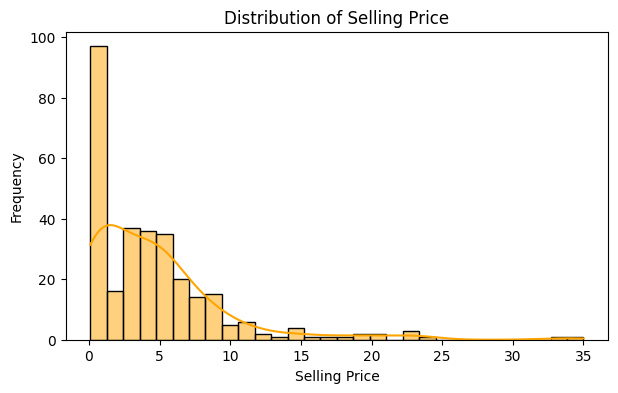

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 4))
sns.histplot(df['Selling_Price'], kde=True, bins=30, color='orange')
plt.title("Distribution of Selling Price")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()


<ipython-input-7-8541dcc265be>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


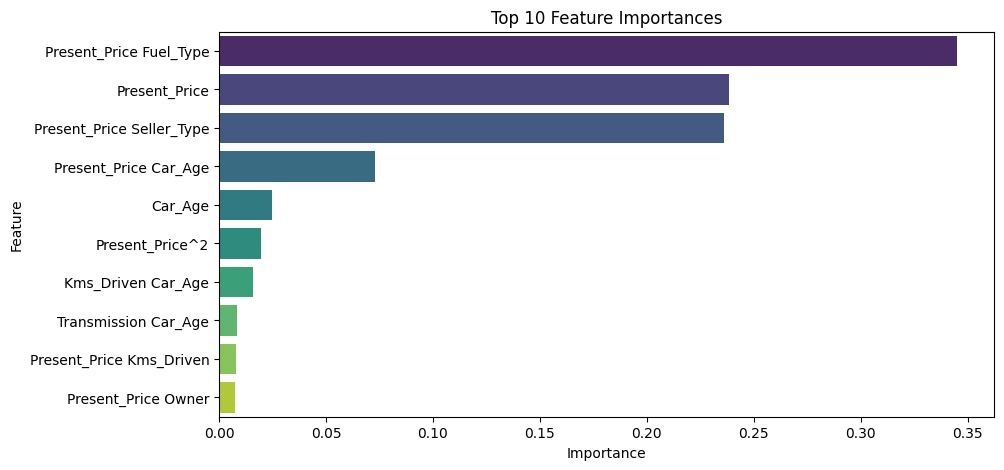

In [7]:
gbr_model = GradientBoostingRegressor().fit(X_train, y_train)
importances = gbr_model.feature_importances_

# Get feature names from polynomial feature generator
feature_names = poly.get_feature_names_out(X.columns)

# Plot top 10 important features
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title("Top 10 Feature Importances")
plt.show()


MODELS USED

In [2]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

# Base models
base_models = [
    ('lr', LinearRegression()),
    ('lasso', Lasso(alpha=0.1)),
    ('tree', DecisionTreeRegressor(max_depth=5)),
    ('gbr', GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=3))
]

# Meta-model
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

# Train the stacking model
stacking_model.fit(X_train, y_train)


StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('lasso', Lasso(alpha=0.1)),
                              ('tree', DecisionTreeRegressor(max_depth=5)),
                              ('gbr',
                               GradientBoostingRegressor(n_estimators=150))],
                  final_estimator=LinearRegression())

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Predictions
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}")

# Evaluate on train and test data
print("\nTrain Performance:")
evaluate_model(y_train, y_train_pred)

print("\nTest Performance:")
evaluate_model(y_test, y_test_pred)



Train Performance:
Mean Absolute Error (MAE): 0.46
Mean Squared Error (MSE): 0.45
Root Mean Squared Error (RMSE): 0.67
R-squared (R²): 0.98

Test Performance:
Mean Absolute Error (MAE): 0.43
Mean Squared Error (MSE): 0.50
Root Mean Squared Error (RMSE): 0.71
R-squared (R²): 0.97


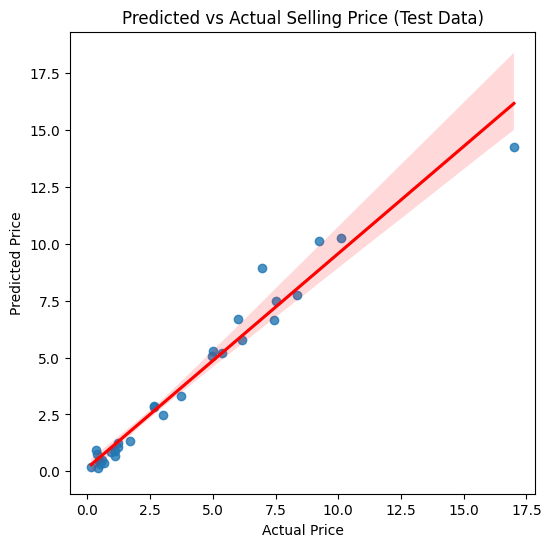

In [10]:
plt.figure(figsize=(6, 6))
sns.regplot(x=y_test, y=y_test_pred, line_kws={'color':'red'})
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Selling Price (Test Data)")
plt.show()


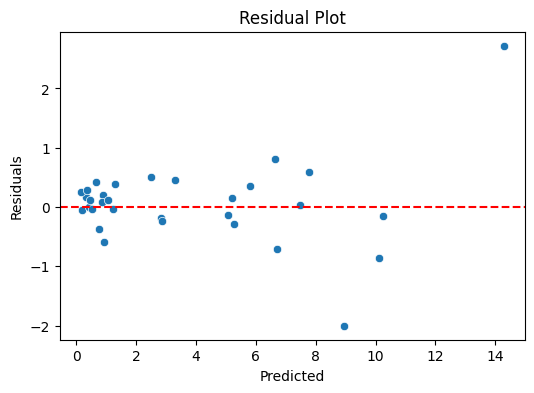

In [11]:
residuals = y_test - y_test_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, dataset_type="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Evaluation Results on {dataset_type} Data:")
    print(f"➡️  R² Score           : {r2:.4f}")
    print(f"➡️  MAE (Mean Abs Err) : {mae:.4f}")
    print(f"➡️  MSE (Mean Sq Err)  : {mse:.4f}")
    print(f"➡️  RMSE               : {rmse:.4f}")

# Train and Test evaluation
evaluate_model(y_train, y_train_pred, "Training")
evaluate_model(y_test, y_test_pred, "Test")



📊 Evaluation Results on Training Data:
➡️  R² Score           : 0.9833
➡️  MAE (Mean Abs Err) : 0.4590
➡️  MSE (Mean Sq Err)  : 0.4497
➡️  RMSE               : 0.6706

📊 Evaluation Results on Test Data:
➡️  R² Score           : 0.9664
➡️  MAE (Mean Abs Err) : 0.4297
➡️  MSE (Mean Sq Err)  : 0.5015
➡️  RMSE               : 0.7082


<Axes: xlabel='Selling_Price', ylabel='Count'>

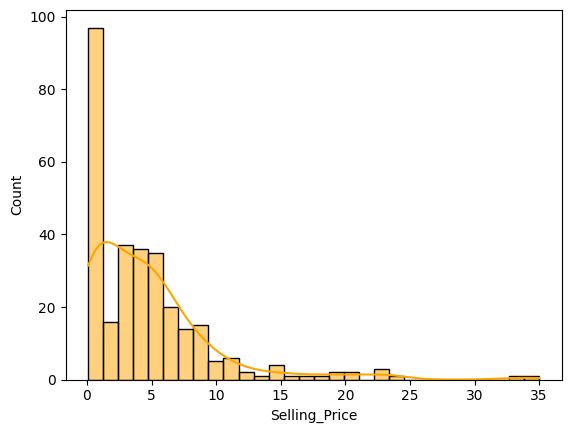

In [13]:
sns.histplot(df['Selling_Price'], kde=True, bins=30, color='orange')

<Axes: xlabel='Selling_Price'>

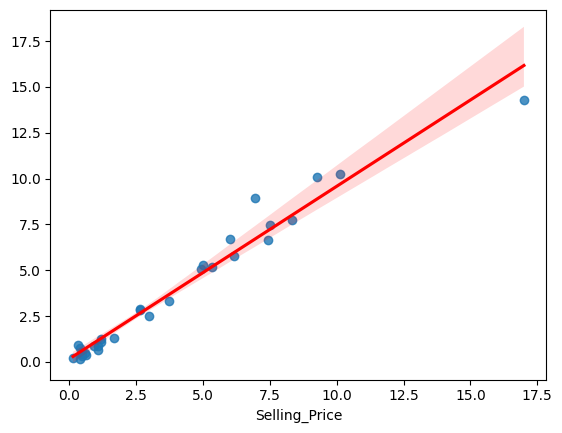

In [14]:
sns.regplot(x=y_test, y=y_test_pred, line_kws={'color':'red'})